# Instacart dataset exploratory
- 인스타카트캐글 : https://www.kaggle.com/c/instacart-market-basket-analysis#prizes
- 필사 연습 참고 사이트: https://brunch.co.kr/@goodvc78/17 (최규민님 블로그)
https://gist.github.com/goodvc78/3653c8f6a510f619d7ad6570111f38d8 (최규민님 깃헙) 감사합니다

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# pd.options.display_max_rows = 20
%matplotlib inline
sns.set(style = 'whitegrid', palette = 'colorblind', font_scale = 1, rc = {'font.family':'NanumGothic'})

In [2]:
def toReadable(v):
    value = round(v, 2) if isinstance(v, float) else v
    
    if value < 1000:
        return str(value)
    elif value < 1000000:
        return str(round(value/1000, 1)) + 'K'
    elif value >= 1000000:
        return str(round(value/1000000, 1)) + 'K'
    return value

## 데이터세트 불러오기

In [3]:
!ls -al ./kaggle/data/instacart/*.csv

'ls'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


In [4]:
raw_order_ds = pd.read_csv('../kaggle/data/instacart/orders.csv')
order_product_ds = pd.read_csv("../kaggle/data/instacart/order_products__prior.csv")
product_ds = pd.read_csv('../kaggle/data/instacart/products.csv')

order_product_cnt_ds = order_product_ds.groupby("order_id").count()[['product_id']]
order_product_cnt_ds.columns = ['product_cnt']

# product 수 합치기
order_ds = raw_order_ds.merge(order_product_cnt_ds, left_on = 'order_id', right_index = True)

### 데이터셋 summary

In [5]:
total_user = len(order_ds.user_id.unique())
total_order = len(order_ds)
total_ordered_product = len(order_product_ds)
unique_products = len(order_product_ds.product_id.unique())

print("total user = {}".format(toReadable(total_user)))
print("total order = {} ({} orders per a user)".format(toReadable(total_order),
                                                       toReadable(total_order / total_user)))
print("total product = ", toReadable(unique_products))
print("total ordered product = {} ({} orders per a product )".format(toReadable(total_ordered_product),
                                                                    toReadable(total_ordered_product / unique_products)))

total user = 206.2K
total order = 3.2K (15.59 orders per a user)
total product =  49.7K
total ordered product = 32.4K (652.91 orders per a product )


## 요일에 따른 시간별 분석 (히트맵)
상품구매가 요일별/시간별(WeekHour) 특징이 있을것으로 보고 그것을 분석하고자 함

In [6]:
index2day = "Sun Mon Tue Wed Thu Fri Sat".split()

In [7]:
def drawWeekHour(ds, values, aggfunc = len, title = None, figsize = (18,5), cmap = None):
    weekhour_ds = ds.pivot_table(index = 'order_dow', columns = 'order_hour_of_day', values = values,
                                aggfunc = aggfunc).fillna(0)
    weekhour_ds.index = [index2day[index] for index in weekhour_ds.index]
    sns.set(style = 'whitegrid', palette = 'colorblind', 
            font_scale = 1, rc = {'font.family' : 'Malgun Gothic'})
    
    plt.figure(figsize = figsize)
    f = sns.heatmap(weekhour_ds, annot = True, fmt = "1.1f", linewidths = .5, cmap = cmap)
    plt.xlabel("Hour")
    plt.ylabel("Day of Week")
    if title:
        plt.title(title, fontsize = 15)

### 주문량 히트맵
일요일/월요일 9H~16H까지 주문(order)가 많은 특징이 있음

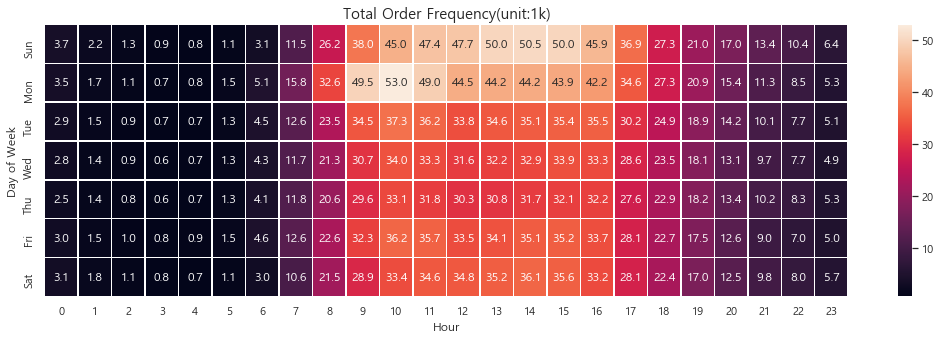

In [8]:
drawWeekHour(order_ds, values = 'order_id', title = "Total Order Frequency(unit:1k)",
             aggfunc = lambda x: len(x)/1000)

> **Q1**. 주문하는 고객이 많은 것인가? 고객당 주문 건수가 많은 것인가?

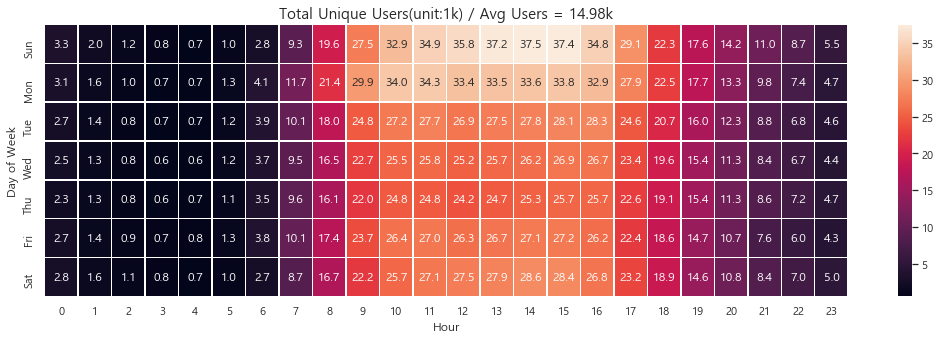

In [9]:
avg_users = round(order_ds.groupby(['order_dow', 
                                    'order_hour_of_day']).agg({'user_id':lambda x: len(x.unique())/1000}).mean().values[0],2)
drawWeekHour(order_ds, values = 'user_id', title = "Total Unique Users(unit:1k) / Avg Users = {}k".format(avg_users),
            aggfunc = lambda x: len(x.unique())/1000)

그럼 이제 고객당 주문 건수를 봅시다.
- 특이하게 `월요일 오전`(8-10시)의 오더가 많다. 이유가 있으려나? (정기주문?)

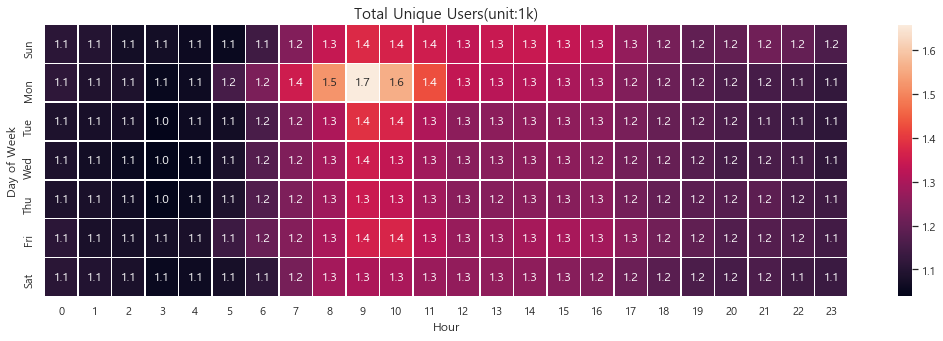

In [10]:
drawWeekHour(order_ds, values = 'user_id', title = "Total Unique Users(unit:1k)",
            aggfunc = lambda x: len(x)/len(x.unique()))

> **A1**. _주문하는 `고객`이 많아서이다._

**그럼 월요일 오전 9시에는 어떤 물건을 사려나?
특히 많이 사는것이 있나?**

In [11]:
merge_order_product_ds = order_product_ds.merge(order_ds, on ='order_id')
merge_order_product_ds = merge_order_product_ds.merge(product_ds, on = 'product_id')

In [14]:
hour_9_order_product_ds = merge_order_product_ds[merge_order_product_ds.order_hour_of_day == 9]
grouped = hour_9_order_product_ds[:].groupby(['order_dow'])

In [16]:
topn = 5
hour_9_popular_product = []
for (dow, rows) in grouped:
    sub_ds = rows.groupby("product_id",
                          as_index = False).agg({'order_id':len}).sort_values('order_id',
                                                                             ascending = False)[:topn]
    sub_ds['dow'] = dow
    sub_ds['rank'] = list(range(0, topn))
    hour_9_popular_product.append(sub_ds)
    
# pd.options.display.max_rows = 200
hour_9_popular_product_ds = pd.concat(hour_9_popular_product).sort_values(['rank','dow']).merge(product_ds, on = 'product_id')\
.pivot(index = 'dow', columns = 'rank', values = 'product_name')
hour_9_popular_product_ds.index = index2day

- 그냥 단지 사람들은 월요일 아침에 다른날보다 바나나와 우유를 많이 먹나보다

In [17]:
hour_9_popular_product_ds

rank,0,1,2,3,4
Sun,Banana,Bag of Organic Bananas,Organic Baby Spinach,Organic Strawberries,Organic Hass Avocado
Mon,Banana,Bag of Organic Bananas,Organic Strawberries,Organic Baby Spinach,Organic Hass Avocado
Tue,Banana,Bag of Organic Bananas,Organic Strawberries,Organic Baby Spinach,Organic Hass Avocado
Wed,Banana,Bag of Organic Bananas,Organic Strawberries,Organic Baby Spinach,Organic Hass Avocado
Thu,Banana,Bag of Organic Bananas,Organic Strawberries,Organic Baby Spinach,Organic Hass Avocado
Fri,Banana,Bag of Organic Bananas,Organic Strawberries,Organic Baby Spinach,Organic Hass Avocado
Sat,Banana,Bag of Organic Bananas,Organic Strawberries,Organic Baby Spinach,Organic Hass Avocado


### 베스트셀러 20개 상품

In [18]:
def topItemEachGroup(ds, group_name, sort_name, topn):
    concat_list = []
    for(key,rows) in ds.groupby(group_name):
        sub_ds = rows.sort_values(sort_name, ascending = False)[:topn]
        sub_ds['rank'] = list(range(1, topn + 1))
        concat_list.append(sub_ds)
        
    return pd.concat(concat_list)

In [28]:
def drawRankTrend(pivot_ds, ylabel='Rank'):
    sns.set(style="whitegrid", palette="colorblind", font_scale=1.3, rc={'font.family':'Malgun Gothic'} )

    index_max = pivot_ds.index.max()
    rank_max = pivot_ds.max().max()
    pivot_ds = pivot_ds.applymap(lambda x:rank_max-x+1)
    pivot_ds.plot(marker='o', figsize=(16,12), cmap='Dark2', xticks=pivot_ds.index, legend=None )
    
    plt.yticks(np.arange(rank_max,0,-1), np.arange(1,rank_max+1))
    for name, rank in pivot_ds.loc[index_max].sort_values(ascending=False).dropna().iteritems():
        plt.text(index_max*1.01,rank,name)
    plt.ylabel(ylabel)
    plt.show()

#### 20가지 베스트 품목 일일그래프

In [26]:
hour_product_ds = merge_order_product_ds.groupby(['product_name','order_hour_of_day'], 
                                                 as_index=False).agg({'order_id':len})
hour_top_product_ds = topItemEachGroup(hour_product_ds, 
                                       'order_hour_of_day', 'order_id' , 20)
hour_top_product_pivot_ds = hour_top_product_ds.pivot(index='order_hour_of_day', 
                                                      columns='product_name', values='rank')

* 1-6위 까지는 거의 변함이 없다.
* 6위 이후의 순위에는 변화가 많다.
* 회사근무시간(9-17)과 그 외 시간의 패턴이 많이 다름을 알 수 있다.

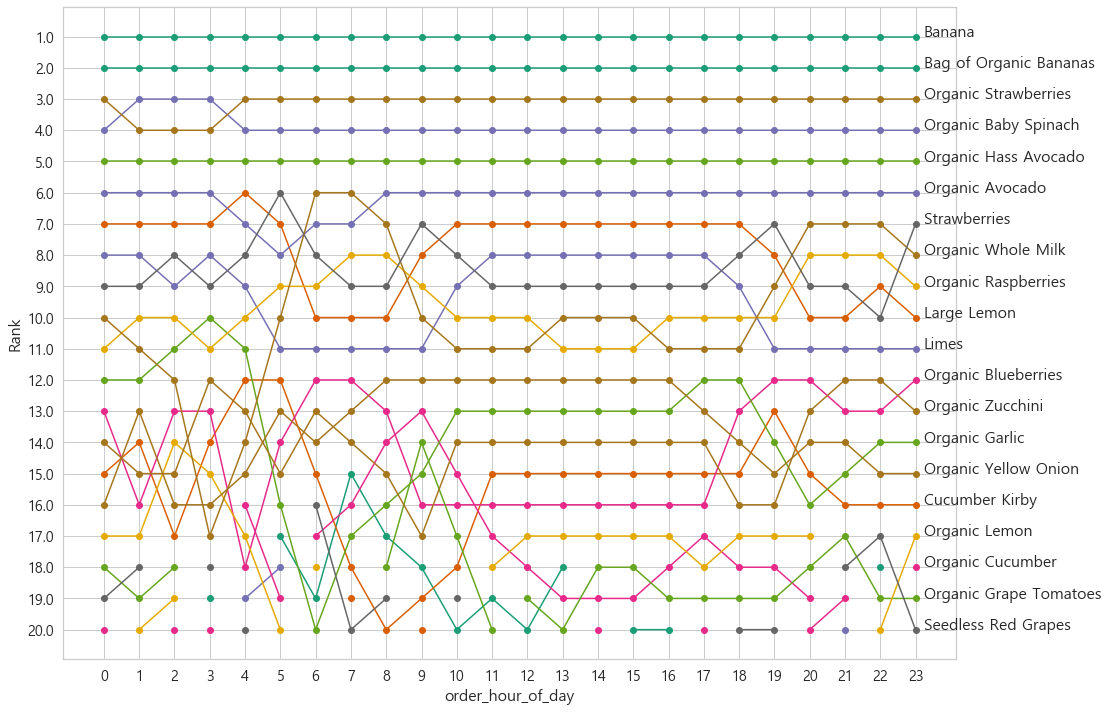

In [29]:
drawRankTrend(hour_top_product_pivot_ds)

#### 20가지 베스트 품목 주간그래프

In [31]:
rank_ds = merge_order_product_ds.groupby(['product_name', 'order_dow'], 
                                         as_index = False).agg({'order_id':len})
rank_ds = topItemEachGroup(rank_ds, 'order_dow', 'order_id', 20)
rank_pivot_ds = rank_ds.pivot(index = 'order_dow', columns = 'product_name', values = 'rank')

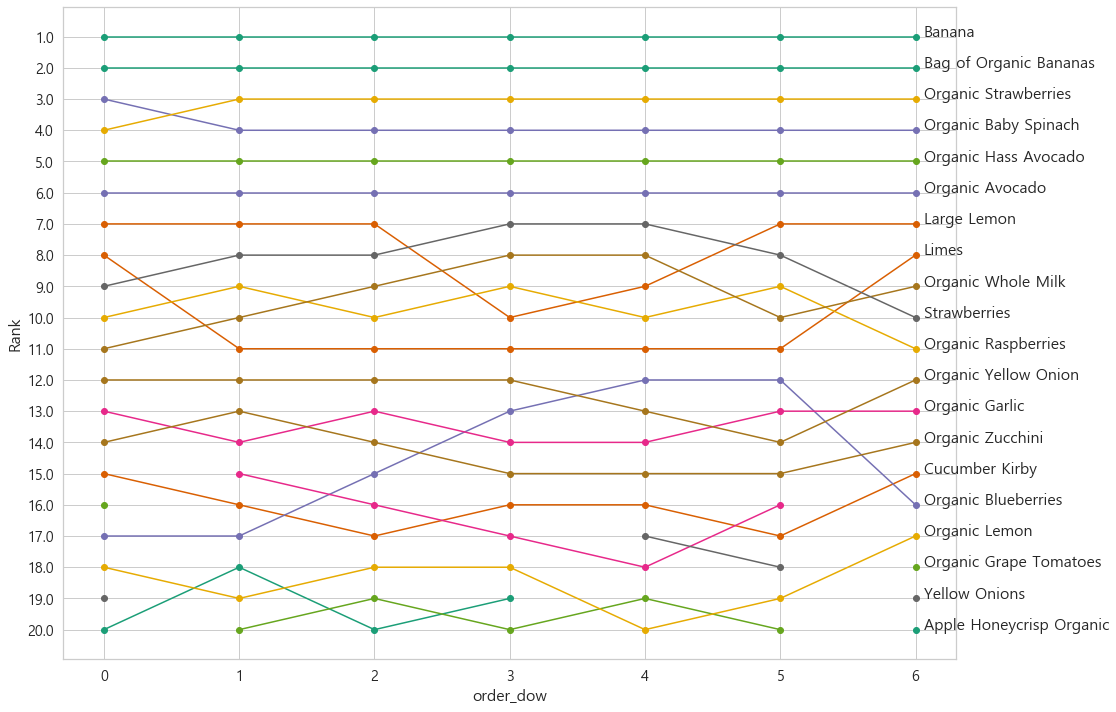

In [32]:
drawRankTrend(rank_pivot_ds)

> **Q2** 한번의 주문(cart)에 상품을 많이 담아 구매하는 요일/시간은?

- Weekday-hour : Product cnt per a order
- 주말(토/일) Order 그리고 밤 (21~23) 늦은 주문시 한번에 주문하는 상품 개수가 많음.
    - 시간적 여유가 많을때 상품 주문량이 많은듯하다.
    - 쇼핑 여유가 있을때와 없을때와의 상품 주문 패턴이 달라질까?

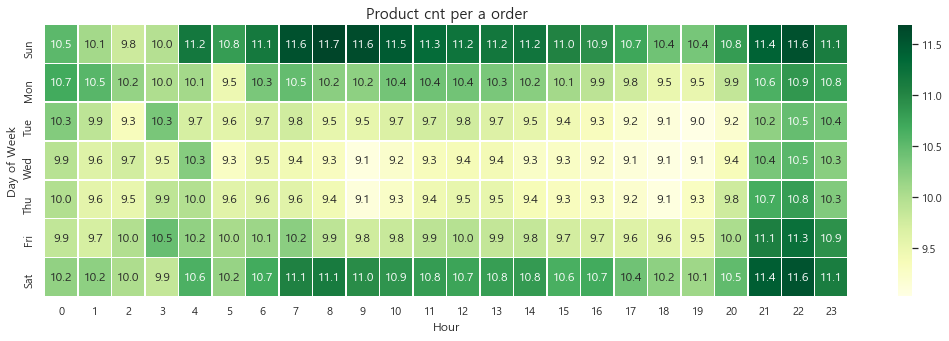

In [33]:
drawWeekHour(order_ds, values = 'product_cnt', title = 'Product cnt per a order',
             aggfunc = lambda x: np.mean(x), cmap = 'YlGn')

#### 얼마나 자주 주문하는가? (재주문까지 걸리는 평균 일수)

- 수치가 작을 수록 첫주문과 다음주문까지의 경과되는 텀 일수가 작음 -> 자주 주문한다고 볼 수 있음
    - 주말과 새벽시간이 재주문까지 걸리는 시간이 김
    - 새벽시간 주문텀이 긴 이유는 새벽에 깨어있을 확률이 적기때문이 아닌가하는 생각이 든다.

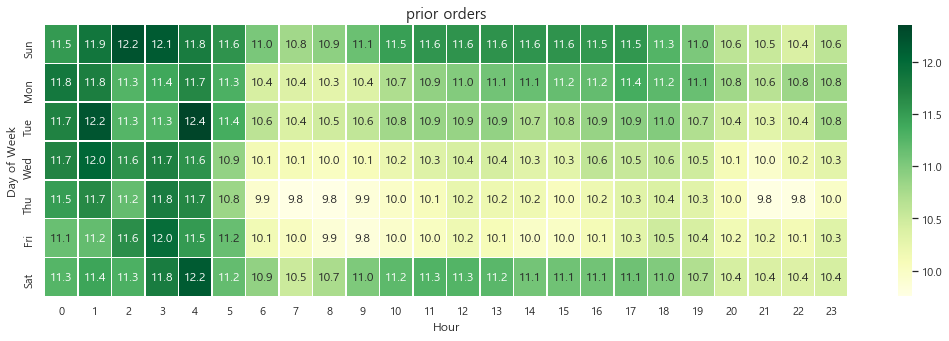

In [34]:
drawWeekHour(order_ds, values = 'days_since_prior_order', title = 'prior orders',
            aggfunc = lambda x: np.mean(x), cmap = 'YlGn')

### 재주문 분석하기

> **Q3** 주문 횟수가 많아질수록 재주문까지 걸리는 텀이 짧아지나? 그렇다!

- 유저별 주문 순번과 재주문까지 경과된 시간 관계는?
    - 주문횟수가 잦다는 것은 충성고객일 가능성 높음. -> 재주문까지의 텀이 짧은것으로 추측가능하다.
- 유저별 주문횟수가 증가할수록 각 주문당 상품 구매수량이 많을까? `상관X`

In [35]:
print("Avg days_since_prior_order {} Days".format(round(order_ds.days_since_prior_order.mean(),2)))

Avg days_since_prior_order 10.71 Days


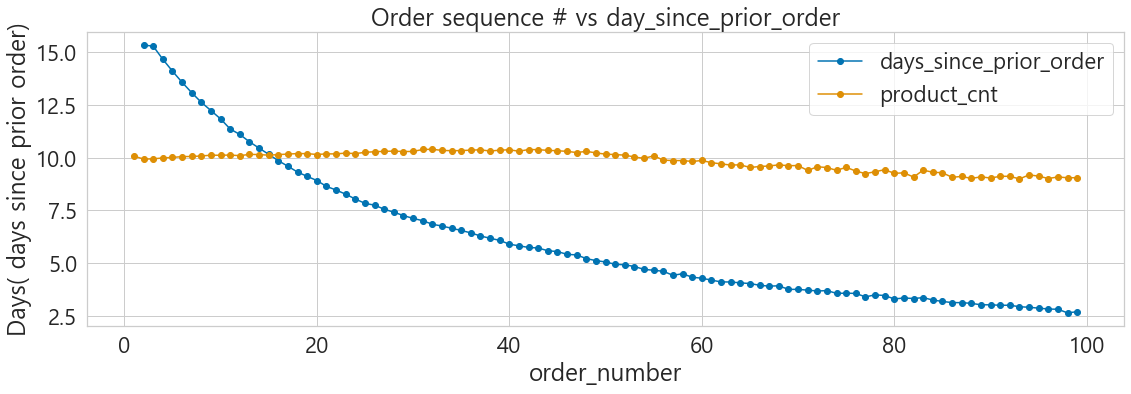

In [36]:
sns.set(style="whitegrid", palette="colorblind", font_scale=2, rc={'font.family':'Malgun Gothic'} )

order_ds.groupby('order_number').agg({'days_since_prior_order' : np.mean, 'product_cnt' : np.mean})\
   .plot(figsize = (16, 6), title = "Order sequence # vs day_since_prior_order", marker = 'o')
plt.ylabel('Days( days since prior order)')
plt.tight_layout()
plt.show()

> **Q4** 재주문 텀이 짧을수록 이전 주문과의 중복 구매상품이 많을까?

In [37]:
merge_order_product_ds = order_product_ds.merge(order_ds, on = 'order_id')

In [38]:
reordered_since_days_ds = merge_order_product_ds.groupby(['days_since_prior_order', 'reordered']).agg({'product_id':len})
reordered_since_days_ds = reordered_since_days_ds.reset_index().pivot(index = 'days_since_prior_order',
                                                                     columns = 'reordered',
                                                                     values = 'product_id')
reordered_since_days_ds['reorder_rate'] = reordered_since_days_ds[1] / reordered_since_days_ds.sum(axis = 1)
avg_reordered_rate = round(reordered_since_days_ds[1].sum() / reordered_since_days_ds[[0, 1]].sum().sum(),2)

> **A4** 다시 주문하는 기간이 짧을수록 재구매 상품비율이 높다.

- 많이 높지는 않다 평균대비 5% 정도?
- 상품예측에 feature로 할 정도의 특징점이 될까?

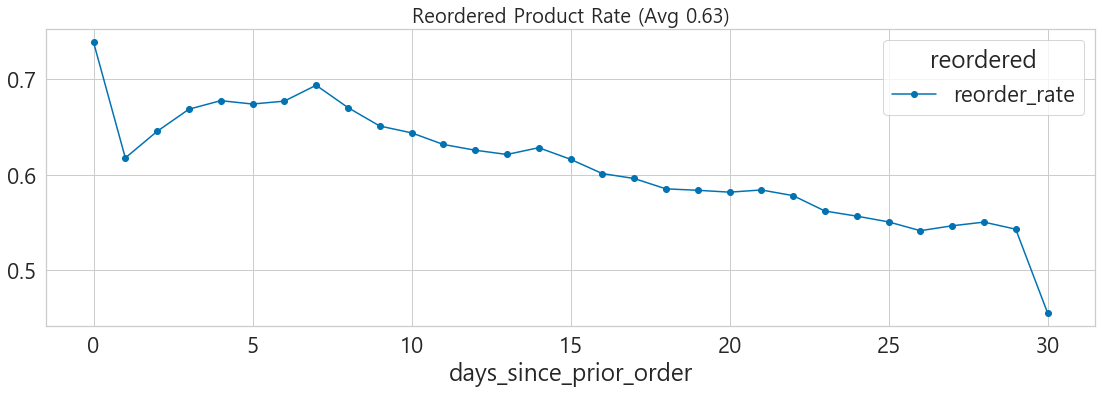

In [40]:
reordered_since_days_ds[['reorder_rate']].plot(kind = 'line', marker = 'o', figsize = (16, 6))
plt.title("Reordered Product Rate (Avg {})".format(avg_reordered_rate), fontsize = 20)
plt.tight_layout()
plt.show()

> **Q5** 주문 순번이 큰 즉, 주문량이 많은 오더에는 재구매 상품이 많을까?

In [41]:
reordered_order_num_ds = merge_order_product_ds.groupby(['order_number', 'reordered']).agg({'product_id':len})
reordered_order_num_ds = reordered_order_num_ds.reset_index().pivot(index = 'order_number',
                                                                   columns = 'reordered',
                                                                   values = 'product_id')
reordered_order_num_ds['reorder_rate'] = reordered_order_num_ds[1] / reordered_order_num_ds.sum(axis = 1)
avg_reordered_rate = round(reordered_order_num_ds[1].sum() / reordered_order_num_ds[[0, 1]].sum().sum(), 2)
reordered_order_num_ds.fillna(0, inplace = True)

> **A5** 주문량이 많은경우 기존 상품을 재구매할 확률이 높다.

- 40번 이상 주문한 사람의주분순번에는 재구매 상품이 80% 이상이다.
- 재구매한 상품이 많기 때문에 주문이 많았다고 보는것도 당연한 이치일듯하다.
- 생각해보면 당연하기 때문에 예측 feature로 쓰기에 적합하다 생각되어진다.

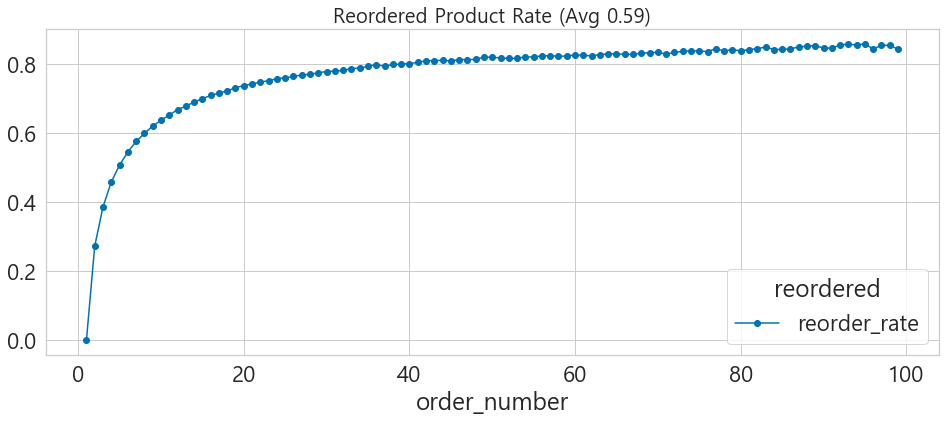

In [42]:
reordered_order_num_ds[['reorder_rate']].plot(kind = 'line', marker = 'o', figsize = (16, 6))
plt.title("Reordered Product Rate (Avg {})".format(avg_reordered_rate), fontsize = 20)
plt.show()

> 재구매율이 높은 상품은 무엇일까?

- 1000개 이상 주문한 상품중 재구매비율이 높은 20개 상품은?

In [43]:
product_reorder_ds = merge_order_product_ds.groupby(['product_id']).agg({'order_id':len,
                                                                        'reordered':lambda x: len(x[x>0]),
                                                                        'user_id':lambda x: len(x.unique())})

In [44]:
convert_colnames = {'user_id':'unique_users', 'reordered':'reorder', 'order_id':'total_order'}
product_reorder_ds.columns = [convert_colnames[col] for col in product_reorder_ds.columns]

In [45]:
product_reorder_ds['reorder_rate'] = round(product_reorder_ds.reorder / product_reorder_ds.total_order, 2)
product_reorder_ds['orders_per_user'] = round(product_reorder_ds.total_order / product_reorder_ds.unique_users, 2)
product_reorder_ds = product_reorder_ds.merge(product_ds, left_index = True, right_on = 'product_id')

> **A6** 84구역의 우유 제품이 대부분의 재구매율을 차지함 (83%)

- 우유이외의 제품은 바나나, 물 등이 있음.
- 당연히 유저당 주문수도 비례해서 높다.

In [46]:
product_reorder_ds[product_reorder_ds.total_order > 1000].sort_values('reorder_rate', ascending = False)\
        [['product_name', 'total_order', 'reorder_rate', 'aisle_id', 'orders_per_user']][:20]

,product_name,total_order,reorder_rate,aisle_id,orders_per_user
45503,Whole Organic Omega 3 Milk,9108,0.86,84,7.15
9291,Half And Half Ultra Pasteurized,2921,0.86,84,7.23
47230,Ultra-Purified Water,1489,0.86,115,7.02
5513,Organic Homogenized Whole Milk,3970,0.86,84,7.03
43393,Organic Lactose Free Whole Milk,8477,0.86,91,7.09
34196,Goat Milk,5185,0.85,84,6.66
29446,"Milk, Organic, Vitamin D",20198,0.85,84,6.87
38688,Organic Reduced Fat Milk,35663,0.85,84,6.70
31719,Organic Whole Milk,9842,0.84,84,6.30
24520,Lowfat Goat Milk,1159,0.84,84,6.20


- 추가로, 구역(aisle)별 재구매 상품 비율 상위20, 하위 20은?

In [48]:
from collections import defaultdict
import operator

def popularWords(names, topn = 2):
    wordFrequency = defaultdict(int)
    def updateWords(words):
        for word in words:
            if len(word) > 1:
                wordFrequency[word] += 1
    names.apply(lambda x: updateWords(x.split()))
    tops = sorted(wordFrequency.items(), key = operator.itemgetter(1), reverse = True)[:topn]
    return " ".join([n[0] for n in tops])

In [49]:
aisle_ds = product_ds.groupby('aisle_id').agg({'product_name':popularWords,
                                              'product_id':lambda x:len(x.unique())})

In [51]:
aisle_order_stat_ds = product_reorder_ds.groupby('aisle_id').agg({'total_order':sum,
                                                                 'reorder':sum})
aisle_order_stat_ds['reorder_rate'] = round(aisle_order_stat_ds.reorder / aisle_order_stat_ds.total_order, 2)
aisle_order_stat_ds = aisle_order_stat_ds.merge(aisle_ds,
                                                left_index = True,
                                                right_index = True).sort_values('reorder_rate',
                                                                               ascending = False)
aisle_order_stat_ds.index = aisle_order_stat_ds.product_name + "(" + aisle_order_stat_ds.index.astype(str) + ")"

- 재구매 비율이 높은 구역(aisle)은 유통기한이 짧은 우유, 물 커피, 주스 등 신선 농산물 위주
- 재구매 비율이 낮은 구역(aisle)은 유통기한이 긴 제품들로 판단되어짐
- 이처럼 재구매 비율이 유통기한(또는 소비기한)에 대비하여 높은지 낮은지에 따라 구매 성향을 더 알수 있을것 같다.

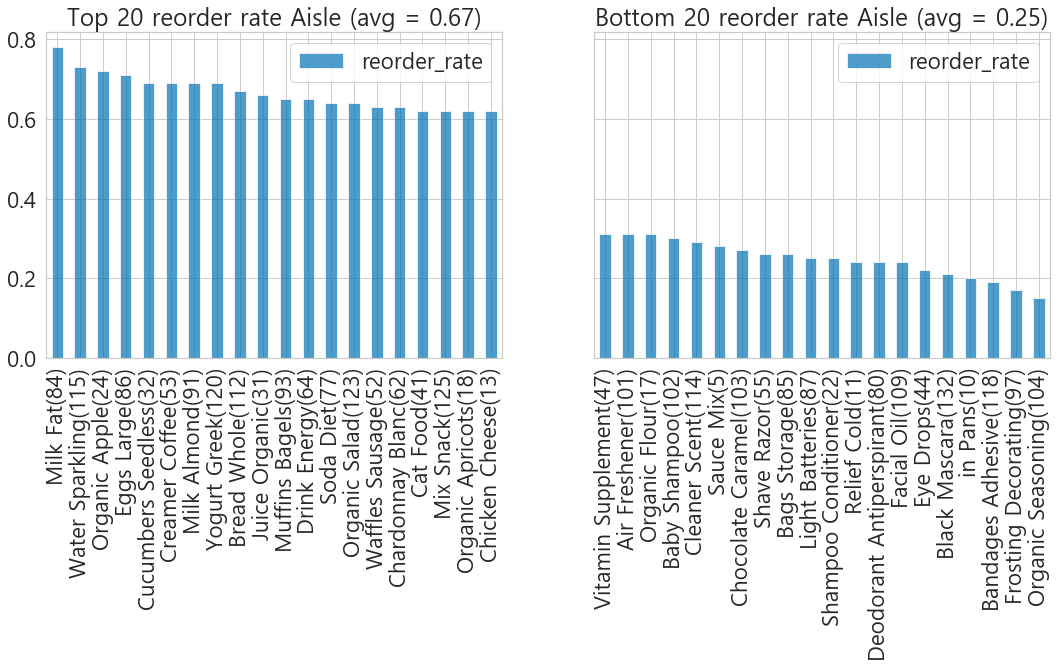

In [53]:
sns.set(style="whitegrid", palette="colorblind", font_scale=2, rc={'font.family':'Malgun Gothic'} )

f, (ax1, ax2) = plt.subplots(1, 2, sharey = True)

top20_ds = aisle_order_stat_ds[['reorder_rate']][:20]
top20_ds.plot(kind = 'bar', figsize = (16, 6),
             alpha = .7, ax = ax1,
             title = 'Top 20 reorder rate Aisle (avg = {})'.format(toReadable(top20_ds.reorder_rate.mean())))

bottom20_ds = aisle_order_stat_ds[['reorder_rate']][-20:]
bottom20_ds.plot(kind = 'bar', figsize = (18, 6), alpha = .7, ax = ax2,
                title = 'Bottom 20 reorder rate Aisle (avg = {})'.format(toReadable(bottom20_ds.reorder_rate.mean())))
plt.show()

> **Q7** 주문이 많은 상품은 재구매율이 높을까?

- 당연히 그럴것이다. 데이터로 확인해보자.
- (참고) reorder_rate(0 ~ 1.), total_order(1~500000)의 데이터 단위가 너무 차이가 나기 때문에 상관계수를 spearman으로 측정

> **A7** 예상대로 주문수와 재구매비율은 양의 상관관계(0.59)를 보인다.

- 이 데이터를 보면서 구매량은 많은 반면 재구매비율이 낮은 상품은 무엇인가?
- 해당 상품들은 발전가능성이 높은가?하는 의문이 들었다.

C:\Users\HJ\anaconda3\lib\site-packages\seaborn\axisgrid.py:2272: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\HJ\anaconda3\lib\site-packages\seaborn\axisgrid.py:1848: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


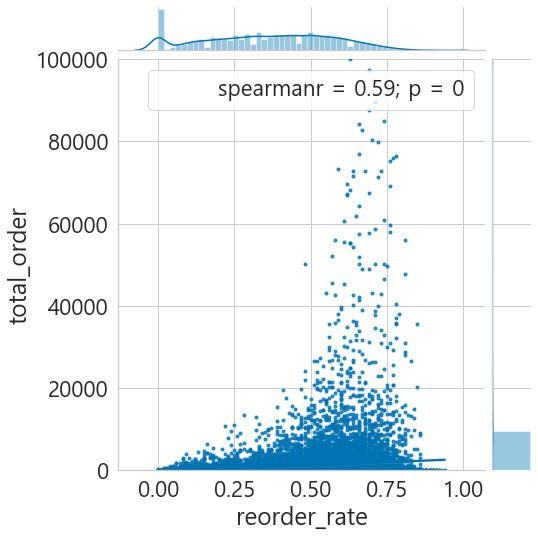

In [55]:
from scipy.stats import spearmanr
g = sns.jointplot("reorder_rate", "total_order", kind = "reg", marker = '.',
                 ylim = (0, 100000), size = 8, ratio = 8,
                 stat_func = spearmanr, data = product_reorder_ds)

## 사용자의 Order 정보로 유사한 상품끼리 묶기
- word2vec으로 product2vec을 만든다.
    - word = product_id
    - order = scentence = [product_id1, product_id2, ...]
- 학습된 product vector로 클러스터링
- 200번 이상 주문된 상품만 학습에 포함

In [56]:
order_product_list = merge_order_product_ds\
    .sort_values(['user_id', 'order_id', 'add_to_cart_order'])[['order_id', 'product_id']]\
    .values.tolist()

product_corpus = []
sentence = []
new_order_id = order_product_list[0][0]
for(order_id, product_id) in order_product_list:
    if new_order_id != order_id:
        product_corpus.append(sentence)
        sentence = []
        new_order_id = order_id
    sentence.append(str(product_id))

In [62]:
from gensim.models import Word2Vec

# model = Word2Vec(product_corpus, window = 6, size = 100, workers = 4, min_count = 200)
# model.save('../kaggle/data/instacart/prod2vec.100d.model')
model = Word2Vec.load('../kaggle/data/instacart/prod2vec.100d.model')

In [63]:
def toProductName(id):
    return product_ds[product_ds.product_id == id]['product_name'].values.tolist()[0]
toProductName(24852)

'Banana'

In [64]:
def most_similar_readable(model, product_id):
    similar_list = [(product_id, 1.0)] + model.wv.most_similar(str(product_id))
    
    return[(toProductName(int(id)), similarity) for (id, similarity) in similar_list]

### What is the most similar?
- most similar to banana(24852) is...

In [65]:
pd.DataFrame(most_similar_readable(model, 24852), columns = ['product', 'similarity'])

,product,similarity
0,Banana,1.000000
1,Bag of Organic Bananas,0.693485
2,Bartlett Pears,0.585493
3,Seedless Red Grapes,0.568169
4,Granny Smith Apples,0.525333
5,Organic Banana,0.522899
6,XL Emerald White Seedless Grapes,0.522207
7,Total 0% Greek Yogurt,0.518481
8,Almond Breeze Original Almond Milk,0.486541
9,Organic Fuji Apple,0.483068


- most similar to Drinking Water(27845) is..

In [66]:
pd.DataFrame(most_similar_readable(model, 27845), columns = ['product', 'similarity'])

,product,similarity
0,Organic Whole Milk,1.000000
1,Organic Reduced Fat Milk,0.778165
2,Organic Lowfat 1% Milk,0.705461
3,Whole Organic Omega 3 Milk,0.699135
4,1% Lowfat Milk,0.630444
5,Organic Lactose Free Whole Milk,0.624228
6,Organic Mini Homestyle Waffles,0.624078
7,Organic Whole Grassmilk Milk,0.619248
8,Organic Multigrain Waffles,0.617950
9,Organic Reduced Fat Omega-3 Milk,0.610136


- most similar to Organic Whole Milk(40939) is..

In [67]:
pd.DataFrame(most_similar_readable(model, 40939), columns = ['product', 'similarity'])

,product,similarity
0,Drinking Water,1.000000
1,Boneless & Skinless Chicken Breasts,0.741543
2,Margarine,0.735869
3,Organic 2% Milk,0.728173
4,Nacho Cheese Flavored Tortilla Chips,0.726859
5,"100% Juice, Variety Pack",0.723139
6,Foam Bowls,0.714115
7,Salted Sweet Cream Butter Quarters,0.714104
8,Diet,0.708321
9,Double Chocolate Muffins,0.704772


In [68]:
pd.DataFrame(most_similar_readable(model, 48697), columns = ['product', 'similarity'])

,product,similarity
0,Canola Oil,1.000000
1,Light Brown Sugar,0.750692
2,Unsalted Butter,0.737320
3,Corn Starch,0.724625
4,Panko Bread Crumbs,0.722797
5,Unbleached Bread Flour,0.716732
6,Refined Canola Oil,0.709459
7,Whole Wheat Flour,0.702864
8,Unbleached All-Purpose Flour,0.695882
9,100% Whole Grain Corn Meal,0.695766


### Product2Vec 잘 학습된듯 하다.
- Kmean로 학습된 Product Vector로 500 clusters 생성
- using kmeans (k = 500)

In [82]:
import kmeans

ModuleNotFoundError: No module named 'kmeans'

In [79]:
def clustering(model, k = 500, delta = 0.00000001, maxiter = 200):
    movie_vec = model.wv.syn0
    cetres, index2cid, dist = kmeans.kmeanssample(movie_vec, k,
                                                 metric = 'cosine',
                                                 delta = delta,
                                                 nsample = 0, maxiter = maxiter,)
    clustered_ds = pd.DataFrame([(a, b, c) for a, b, c in zip(model.wv.index2word,
                                                              index2cid, dist)],
                               columns = ['product_id', 'cid', 'dist']).sort_values(['cid', 'dist'],
                                                                                   ascending = True)
    prod2cid = {product_id:cid for product_id, cid in zip(model.wv.index2word, index2cid)}
    
    return(centres, index2cid, dist, clustered_ds, prod2cid)

In [80]:
(centres, index2cid, dist, clustered_ds, prod2cid) = clustering(model)

C:\Users\HJ\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  


NameError: name 'kmeans' is not defined